# Bayesian Optimization
Idea: Use bayesian optimization for (wrapper) feature selection.

In [60]:
from sklearn import datasets
import pandas as pd
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from bayes_opt import BayesianOptimization
from itertools import chain, combinations
from skopt import gp_minimize
import matplotlib.pyplot as plt

## 0. Hyperparameters

In [61]:
k_features = 7 # number of features which we want to get

## 1. Choose dataset

In [62]:
# regression dataset
dataset = datasets.load_boston()

In [63]:
# classification dataset
dataset = datasets.load_wine()

In [64]:
# classification dataset
dataset = datasets.load_breast_cancer()

## 2. Import dataset

In [65]:
# define which dataset should be used
data = dataset.data
data_target = dataset.target
feature_names = dataset.feature_names

data_frame = pd.DataFrame(data, columns = feature_names)
data_frame['Target'] = data_target
X = data_frame.drop("Target", 1)       # feature matrix
y = data_frame['Target'] 
data_frame.head()

#print(data)
#print(target_matrix)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## 3. Classical Feature Selection Algorithms

### 3.1 Sequential Forward Selection (mlxtend SFS)
- https://github.com/rasbt/mlxtend

In [79]:
forward_selection = SFS(LinearRegression(),
          k_features=k_features,
          forward=True,
          floating=False,
          scoring = 'r2',
          cv = 0)

In [80]:
forward_selection.fit(X, y)
res_sfs = tuple(sorted(forward_selection.k_feature_names_))
res_sfs

('compactness error',
 'smoothness error',
 'worst area',
 'worst concave points',
 'worst radius',
 'worst symmetry',
 'worst texture')

### 3.2 Recursive Feature Elimination (sklearn RFE)
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [81]:
rfe_selection = RFE(LinearRegression(),
               n_features_to_select=k_features,
               step=1)

In [83]:
rfe_selection.fit(X, y)
rfe_support = rfe_selection.support_

# convert to k-feature-names tuple
res_rfe_temp = []
for i in range(0,len(feature_names)):
    if rfe_support[i]:
        res_rfe_temp.append(feature_names[i])
res_rfe = tuple(sorted(res_rfe_temp)) # convert to tuple
res_rfe

('concave points error',
 'mean concave points',
 'mean fractal dimension',
 'mean smoothness',
 'smoothness error',
 'worst fractal dimension',
 'worst smoothness')

## 4. Bayesian Optimization Algorithm

### 4.1 Create feature-subsets (wrapper)

In [92]:
s = feature_names 
wrapper = list(combinations(s, k_features))

### 4.2  fmfn / BayesianOptimization Package 
- https://github.com/fmfn/BayesianOptimization

In [93]:
def black_box_function_bay_opt(x):
    x = round(x)
    filteredX = X[X.columns[X.columns.isin(wrapper[x])]] # use only selected features
    model = LinearRegression().fit(filteredX, y)
    return model.score(filteredX, y)


In [94]:
pbounds = {'x': (1, len(wrapper)-1)}

In [95]:
optimizer_fmfn = BayesianOptimization(
    f=black_box_function_bay_opt,
    pbounds=pbounds,
    verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=123,
)

In [98]:
optimizer_fmfn.maximize(
    init_points=5,
    n_iter=50,
    acq = 'poi',
)
print(optimizer_fmfn.max["target"])
print(round(optimizer_fmfn.max["params"]["x"]))

res_fmfn = tuple(sorted(wrapper[round(optimizer_fmfn.max["params"]["x"])]))
res_fmfn

|   iter    |  target   |     x     |
-------------------------------------
0.7277123647247483
1464782


('mean concave points',
 'mean fractal dimension',
 'mean smoothness',
 'worst area',
 'worst concavity',
 'worst radius',
 'worst texture')

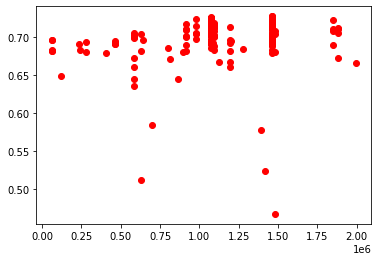

In [99]:
plot_x = []
plot_y = []
for element in optimizer_fmfn.res:
    plot_y.append(element['target'])
    plot_x.append(element['params']['x'])

plt.plot(plot_x, plot_y, 'ro')
plt.show()

### 4.3 scikit-optimize (skopt)
- https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html

In [100]:
def black_box_function_scikit_optimize(x):
    x = x[0]
    
    filteredX = X[X.columns[X.columns.isin(wrapper[x])]] # use only selected features
    model = LinearRegression().fit(filteredX, y)
    return 1-model.score(filteredX, y)


In [105]:
optimizer_skopt = gp_minimize(black_box_function_scikit_optimize, # the function to minimize
                  [(1, len(wrapper)-1)],      # the bounds on each dimension of x
                  acq_func="PI",      # the acquisition function
                  n_calls=50,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  #noise=0.1**2,       # the noise level (optional)
                  random_state=123,  # the random seed
                  verbose=False)  

print(1-optimizer_skopt.fun)
print(optimizer_skopt.x)

res_skopt = tuple(sorted(wrapper[round(optimizer_skopt.x[0])]))
res_skopt

0.7289717784195217
[2035689]


('worst area',
 'worst fractal dimension',
 'worst perimeter',
 'worst radius',
 'worst smoothness',
 'worst symmetry',
 'worst texture')

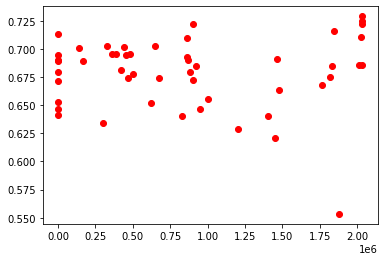

In [106]:
plot_x = optimizer_skopt.x_iters
plot_y = [1-i for i in optimizer_skopt.func_vals]
plt.plot(plot_x , plot_y, 'ro')
plt.show()

## 5. Results

In [107]:
# forward selection algorithm
res_sfs

('compactness error',
 'smoothness error',
 'worst area',
 'worst concave points',
 'worst radius',
 'worst symmetry',
 'worst texture')

In [108]:
# recursive feature elimination
res_rfe

('concave points error',
 'mean concave points',
 'mean fractal dimension',
 'mean smoothness',
 'smoothness error',
 'worst fractal dimension',
 'worst smoothness')

In [109]:
# fmfn bayesian optimization
res_fmfn

('mean concave points',
 'mean fractal dimension',
 'mean smoothness',
 'worst area',
 'worst concavity',
 'worst radius',
 'worst texture')

In [110]:
# skopt bayesian optimization
res_skopt

('worst area',
 'worst fractal dimension',
 'worst perimeter',
 'worst radius',
 'worst smoothness',
 'worst symmetry',
 'worst texture')